# NIPS Publications Analysis

## 1. Background

The purpose of this project is to use data on published academic papers to investigate trends in machine learning research over recent decades (1987-2017). The data is an archive of 7,241 publications from the Neural Information Processing Systems (NIPS) conferences. This data has been obtained from Kaggle.com.

## 2. Import modules

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import warnings
from sklearn.decomposition import LatentDirichletAllocation as LDA

## 3. Load NIPS data

In [2]:
# Read '~/Documents/data/NIPS_publications_analysis/papers.csv' into papers
papers = pd.read_csv('~/Documents/data/NIPS_publications_analysis/papers.csv')

In [3]:
# Print out the first rows of papers
print(papers.head())

     id  year                                              title event_type  \
0     1  1987  Self-Organization of Associative Database and ...        NaN   
1    10  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   
2   100  1988  Storing Covariance by the Associative Long-Ter...        NaN   
3  1000  1994  Bayesian Query Construction for Neural Network...        NaN   
4  1001  1994  Neural Network Ensembles, Cross Validation, an...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   
2  100-storing-covariance-by-the-associative-long...  Abstract Missing   
3  1000-bayesian-query-construction-for-neural-ne...  Abstract Missing   
4  1001-neural-network-ensembles-cross-validation...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATI

## 4. Prepare the data for analysis

For our analysis, we only need to keep each paper's text data as well as the year in which it was published. The other columns can therefore be removed.

In [4]:
# Print out the column names of papers
papers.columns

Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')

In [5]:
# Drop the columns: 'id', 'event_type', and 'pdf_name'
papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1, inplace=True)

In [6]:
# Print out the column names of papers
papers.columns

Index(['year', 'title', 'abstract', 'paper_text'], dtype='object')

In [7]:
# Print out the first rows of papers
print(papers.head())

   year                                              title          abstract  \
0  1987  Self-Organization of Associative Database and ...  Abstract Missing   
1  1987  A Mean Field Theory of Layer IV of Visual Cort...  Abstract Missing   
2  1988  Storing Covariance by the Associative Long-Ter...  Abstract Missing   
3  1994  Bayesian Query Construction for Neural Network...  Abstract Missing   
4  1994  Neural Network Ensembles, Cross Validation, an...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...  
1  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...  
2  394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...  
3  Bayesian Query Construction for Neural\nNetwor...  
4  Neural Network Ensembles, Cross\nValidation, a...  


## 5. Visualise evolution of machine learning research over time

In [8]:
# Group the data by year
groups = papers.groupby('year')

In [9]:
# Find the size of each group
counts = groups.size()

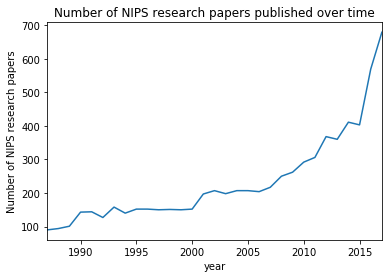

In [10]:
# Plot the numbers of papers published each year
counts.plot(kind='line')
plt.title('Number of NIPS research papers published over time')
plt.ylabel('Number of NIPS research papers')
plt.show()

## 6. Preprocess text data

In [11]:
# Print the titles of the first rows 
print(papers['title'].head())

0    Self-Organization of Associative Database and ...
1    A Mean Field Theory of Layer IV of Visual Cort...
2    Storing Covariance by the Associative Long-Ter...
3    Bayesian Query Construction for Neural Network...
4    Neural Network Ensembles, Cross Validation, an...
Name: title, dtype: object


In [12]:
# Remove punctuation
papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?:]', '', x))

# Convert the titles to lowercase
papers['title_processed'] = papers['title_processed'].str.lower()

# Print the processed titles of the first rows 
print(papers['title_processed'].head())

0    self-organization of associative database and ...
1    a mean field theory of layer iv of visual cort...
2    storing covariance by the associative long-ter...
3    bayesian query construction for neural network...
4    neural network ensembles cross validation and ...
Name: title_processed, dtype: object


## 7. Visualise preprocessed text data with a word cloud

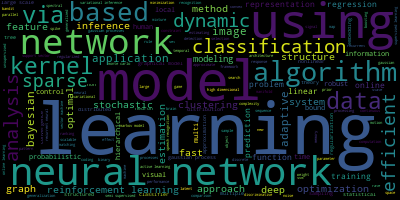

In [13]:
# Join the different processed titles together.
long_string = ' '.join(papers['title_processed'])

# Create a WordCloud object
wc = wordcloud.WordCloud()

# Generate a wordcloud using long_string
wc.generate(long_string)

# Display wordcloud
wc.to_image()

## 8. Prepare data for Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is an unsupervised learning technique for natural language processing. Here we will use it to group the words in the research paper titles into topics, and then grouping the titles by topic.

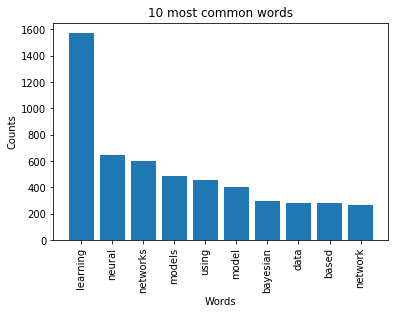

In [40]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, year=None):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    if year == None:
        title = '10 most common words'
    else:
        title = str(year) + ': 10 most common words'
    plt.title(title)
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['title_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## 8. Analyse topics using LDA over whole period

In [23]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Hyperparameters
number_topics = 10
number_words = 3

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
clustering based image

Topic #1:
learning multi large

Topic #2:
bounds boosting error

Topic #3:
learning reinforcement supervised

Topic #4:
time visual brain

Topic #5:
convex convergence optimization

Topic #6:
optimization selection robust

Topic #7:
neural networks network

Topic #8:
estimation learning matrix

Topic #9:
models gaussian inference


## 9. Analyse changes in topics over time

In [48]:
# Hyperparameters
number_topics = 5
number_words = 4

# Iterate through each year of data
for year in papers['year'].unique():
    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english')

    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(papers[papers['year'] == year]['title_processed'])

    # Create and fit the LDA model
    lda = LDA(n_components=number_topics)
    lda.fit(count_data)

    # Print the topics found by the LDA model
    print('--------------', year, '--------------')
    print("Topics found via LDA:")
    print_topics(lda, count_vectorizer, number_words)

-------------- 1987 --------------
Topics found via LDA:

Topic #0:
neurons processing associative memory

Topic #1:
learning neural network networks

Topic #2:
neural network networks artificial

Topic #3:
networks neural systems memories

Topic #4:
neural networks associative application
-------------- 1988 --------------
Topics found via LDA:

Topic #0:
learning network neural networks

Topic #1:
network connectionist sensory neural

Topic #2:
networks modeling analog learning

Topic #3:
neural networks analog recognition

Topic #4:
neural network learning networks
-------------- 1994 --------------
Topics found via LDA:

Topic #0:
neural networks learning model

Topic #1:
learning mixtures reinforcement using

Topic #2:
learning neural network cortex

Topic #3:
neural networks using network

Topic #4:
networks neural learning dynamic
-------------- 1995 --------------
Topics found via LDA:

Topic #0:
networks learning neural based

Topic #1:
model learning data recognition

Topic #

-------------- 1993 --------------
Topics found via LDA:

Topic #0:
networks learning neural models

Topic #1:
network neural using backpropagation

Topic #2:
networks neural learning using

Topic #3:
learning dynamic recognition using

Topic #4:
neural network learning classification
